In [25]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from itertools import permutations
from tqdm import tqdm
import pylab
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Approximation of the measure

In [26]:
def bar_to_coord(point):
    if (len(point) != 3):
        print("WRONG DIMENSION")
        return
    point = point / np.sum(point)
    return np.array([0, 0]) * point[0] + np.array([1, 0]) * point[1] + np.array([0, 1]) * point[2]

def bar_to_triag(point):
    if (len(point) != 3):
        print("WRONG DIMENSION")
        return
    point = point / np.sum(point)
    return np.array([0, 0]) * point[0] + np.array([1, 0]) * point[1] + np.array([0.5, np.sqrt(3) / 2]) * point[2]

def get_area(triag): # return renormalized triangle area
    p1 = bar_to_triag(triag[0])
    p2 = bar_to_triag(triag[1])
    p3 = bar_to_triag(triag[2])
    
    return 0.5 * abs((p2[0] - p1[0]) * (p3[1] - p1[1]) - (p3[0] - p1[0]) * (p2[1] - p1[1])) / (np.sqrt(3) / 4)

def is_inside(point, triag, e_num): # says if point is inside triag
    coefs = np.linalg.solve(triag.T, point)
    if np.min(coefs) > -e_num:
        return True
    return False

def tr_is_inside(triag1, triag, e_num):
    return is_inside(triag1[0], triag, e_num) and is_inside(triag1[1], triag, e_num) and is_inside(triag1[2], triag, e_num)

In [27]:
M_321 = np.array([[1, 1, 0], [0, 1, 0], [0, 0, 1]])
M_312 = np.array([[1, 0, 0], [1, 1, 0], [0, 0, 1]])
M_231 = np.array([[1, 0, 1], [0, 1, 0], [0, 0, 1]])
M_213 = np.array([[1, 0, 0], [0, 1, 0], [1, 0, 1]])
M_132 = np.array([[1, 0, 0], [0, 1, 1], [0, 0, 1]])
M_123 = np.array([[1, 0, 0], [0, 1, 0], [0, 1, 1]])

def F(x): # BRUN
    if (len(x) != 3):
        print("WRONG DIMENSION")
        return
    x = x / np.sum(x)
    # Choosing proper matrix
    if x[0] >= x[1] >= x[2]: # CODE: 321
#         print("321")
        M = M_321
    elif x[1] >= x[0] >= x[2]:
#         print("312")
        M = M_312
    elif x[0] >= x[2] >= x[1]:
#         print("231")
        M = M_231
    elif x[1] >= x[2] >= x[0]:
#         print("132")
        M = M_132
    elif x[2] >= x[1] >= x[0]:
#         print("123")
        M = M_123
    elif x[2] >= x[0] >= x[1]:
#         print("213")
        M = M_213
    res = np.dot(np.linalg.inv(M), np.transpose(x))
    return res / np.sum(res)

def stab_vert(vert1, vert2, vert3, e_num):
    if abs(np.sort(vert1)[2] - np.sort(vert1)[1]) > e_num:
        return vert1
    else:
        res = vert1 + (vert2 + vert3) * e_num ** 2
        return res / np.sum(res)

def F_tr(triag, e_num):
    res = []
    v1 = triag[0]
    v2 = triag[1]
    v3 = triag[2]
    res.append(F(stab_vert(v1, v2, v3, e_num)))
    res.append(F(stab_vert(v2, v1, v3, e_num)))
    res.append(F(stab_vert(v3, v2, v1, e_num)))
    res = np.array(res)
    return res

In [28]:
def get_vertices(C):
    verts = []
    C_in = np.vstack([C[0], C[1] - C[0], C[2] - C[1]]) #inequalities which define the triangle
    for i in range(len(C)):
        C_new = np.delete(C_in, (i), axis=0)
        A = np.vstack([C_new, np.array([[1, 1, 1]])])
        b = np.array([0, 0, 1])
        r = np.linalg.solve(A, b)
        verts.append(r / np.sum(r))
    verts = np.array(verts)
    return verts

def get_partition(depth):
    part = []
    if depth == 1:
        for p in permutations([[1, 0, 0], [0, 1, 0], [0, 0, 1]]):
            part.append(np.array(p))
    else:
        pre_part = get_partition(depth - 1)
        for p in pre_part:
            p = np.array(p)
            part.append(np.vstack([[p[0], p[1], p[2] - p[1]]]))
            part.append(np.vstack([[p[0], p[2] - p[1], p[1]]]))
            part.append(np.vstack([[p[2] - p[1], p[0], p[1]]]))
    return part

def get_partition_vertices(depth):
    part = get_partition(depth)
    verts = []
    for C in part:
        verts.append(get_vertices(C))
    return verts


In [29]:
def is_equal(verts1, verts2, e_num): #tested
    for v1 in verts1:
        has_matched = False
        for v2 in verts2:
            if np.max(np.absolute(v1 - v2)) < e_num:
                has_matched = True
        if not has_matched:
            return False
    return True

def get_preimage(verts, depth, pre_partition, e_num): #tested, important that pre_partition has depth + 1
    preimage = []
    for triag in pre_partition:
        if is_equal(F_tr(triag, e_num), verts, e_num):
            preimage.append(triag)
    return np.array(preimage) 

In [30]:
e_num = 0.00001
depth = 4
partition_n = 2 * 3 ** depth
print("Partition size is " + str(partition_n))
partition = get_partition_vertices(depth)
pre_partition = get_partition_vertices(depth + 1)
P_raw = np.zeros((partition_n, partition_n))

for j in tqdm(range(partition_n)):
    triag_j = partition[j]
    triag_pre = get_preimage(triag_j, depth, pre_partition, e_num)
#     print(len(triag_pre))
#     if (len(triag_pre) < 3):
#         print(triag_j)
    for i in range(partition_n):
        triag_i = partition[i]   
        inter_area = 0.0
        for pre in triag_pre:
            if tr_is_inside(pre, triag_i, e_num):
                inter_area += get_area(pre)
        P_raw[i][j] += inter_area / get_area(triag_i) ** 1

  0%|          | 0/162 [00:00<?, ?it/s]

Partition size is 162


100%|██████████| 162/162 [00:14<00:00, 11.30it/s]


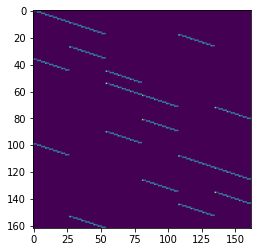

In [31]:
pylab.imshow((P_raw))
pylab.show()

In [32]:
np.min(np.sum(P_raw, axis=1)), np.max(np.sum(P_raw, axis=1))

(0.9999999999999933, 1.0000000000000049)

In [33]:
P_stoch = P_raw

In [34]:
b0 = np.ones(P_stoch.shape[0])
for i in range(1000):
    b_new = np.dot(b0, P_stoch)
    print(np.max(np.abs(b0 - b_new)))
    b0 = b_new

0.9587301587301598
1.4060193774479517
1.287898936858741
0.5638160549525928
0.28447679039680285
0.14559119459535275
0.07639776036448787
0.03942958229325111
0.02028169257075252
0.010464554229006495
0.0054031816314275005
0.0027884816225469677
0.0014387584000310483
0.0007424229113510705
0.0003831219355499016
0.00019770385865136575
0.00010202067045028684
5.2645640836956886e-05
2.7166758524543866e-05
1.4018871152821077e-05
7.234158354130216e-06
3.733043064890751e-06
1.926362626747391e-06
9.940611178649306e-07
5.129654541136119e-07
2.647056129845282e-07
1.365960633492591e-07
7.048768058126598e-08
3.637376444487472e-08
1.87699580322942e-08
9.685863666675232e-09
4.998197411509864e-09
2.5792203928176605e-09
1.3309557900242908e-09
6.868141610993916e-10
3.5441694024029857e-10
1.82890147470971e-10
9.437695069891561e-11
4.870148728741697e-11
2.5131896563834744e-11
1.2969181284461229e-11
6.693312570860144e-12
3.454125874213787e-12
1.7834622667578515e-12
9.201528428093297e-13
4.75175454539567e-13
2.45

In [35]:
xs = []
ys = []
density = []
summ = 0
summ_d = 0
b1 = []
for i in range(partition_n):
    p = partition[i]
    mid = (p[0] + p[1] + p[2]) / 3
    mid_s = np.sort(mid)
    summ += get_area(p) * b0[i]
    b1.append(get_area(p))
    summ_d += 1 / (2 * mid_s[1] * (1 - mid_s[1]) * (1 - mid_s[0] - mid_s[1])) * get_area(p)
    xs.append(bar_to_coord(mid)[0])
    ys.append(bar_to_coord(mid)[1])
    density.append(1 / (2 * mid_s[1] * (1 - mid_s[1]) * (1 - mid_s[0] - mid_s[1])))
xs = np.array(xs)
ys = np.array(ys)
density = np.array(density)

In [36]:
summ, summ_d

(1.8837779891081645, 4.638288492219254)

In [37]:
b0 = b0 / summ

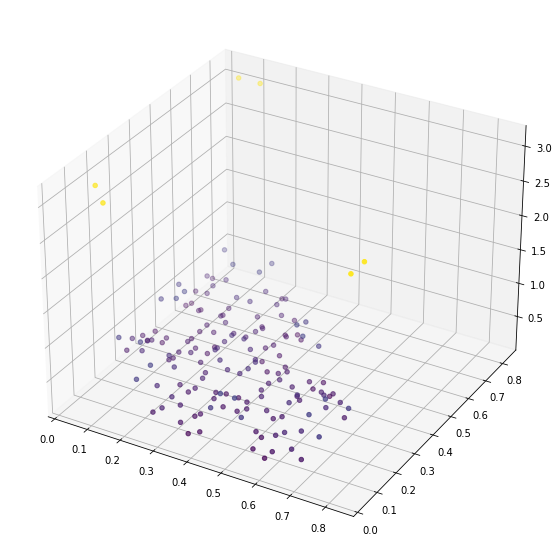

In [50]:
# !matplotlib notebook c=(0.1 ** b0)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, b0, c=( b0))
# for angle in range(0, 180):
#     ax.view_init(0, angle)

# plt.savefig("./InvariantBrun" + str(depth) + "_1.png")
plt.show()

In [47]:
b1 = np.array(b1)
b1 = b1 / np.sum(b1)

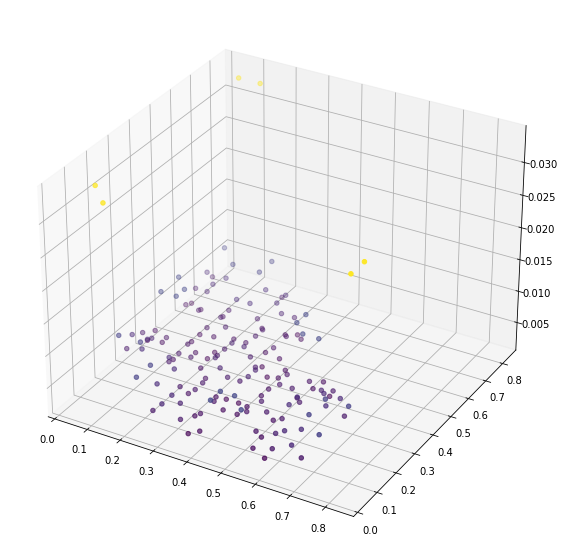

In [48]:
# !matplotlib notebook c=(0.1 ** b0)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, b1, c=(b1))
# for angle in range(0, 180):
#     ax.view_init(0, angle)

# plt.savefig("./InvariantBrun" + str(depth) + "_1.png")
plt.show()

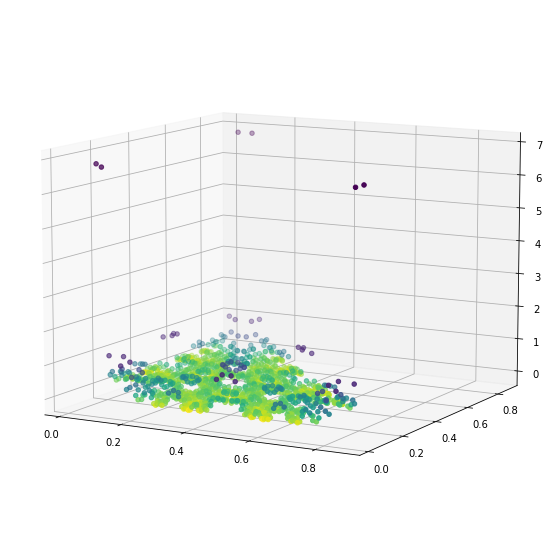

In [21]:
# !matplotlib notebook c=(0.1 ** b0)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, b0, c=(0.1 ** b0))
for angle in range(0, 300):
    ax.view_init(10, angle)

plt.savefig("./InvariantBrun" + str(depth) + "_2.png")
plt.show()

### Code for visualizing partition

In [22]:
part = get_partition_vertices(depth)
len(part)

1458

In [23]:
def to_polygon(triag):
    x = []
    y = []
    for p in triag:
        p1 = bar_to_triag(p)
        x.append(p1[0])
        y.append(p1[1])
    return [x, y]

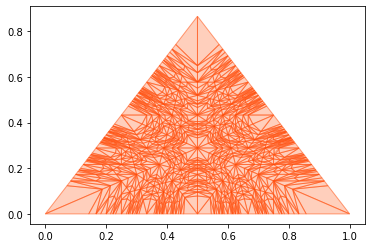

In [24]:
for p in part:
    plt.fill(to_polygon(p)[0], to_polygon(p)[1], facecolor='lightsalmon', edgecolor='orangered', alpha=0.5)
plt.savefig("./PartitionBrun" + str(depth) + ".png")